In [1]:
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
np.random.seed(1)

In [2]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
# Label encode targets
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['dx'])
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2


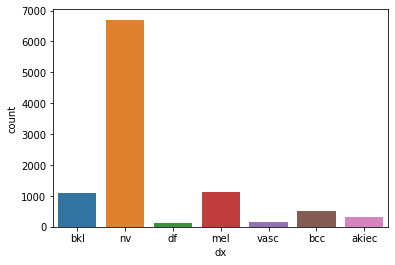

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [4]:
# Count distribution shows data is very imbalanced
sns.countplot(x='dx', data=df)
plt.show()
print(df['dx'].value_counts())
print(df['label'].value_counts())

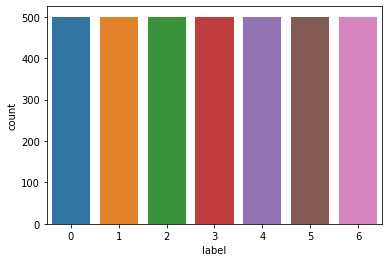

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [5]:
# Resample to balance the data
df_balanced = pd.concat([resample(df[df['label'] == i], replace=True, n_samples=500, random_state=1) for i in range(7)])
sns.countplot(x='label', data=df_balanced)
plt.show()
print(df_balanced['label'].value_counts())

In [6]:
# Add image paths to dataframe
paths = {os.path.splitext(os.path.basename(x))[0]:x for x in glob(os.path.join('../input/skin-cancer-mnist-ham10000/', '*', '*.jpg'))}
df_balanced['path'] = df['image_id'].map(paths.get)
df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path
9724,HAM_0007354,ISIC_0027719,akiec,histo,60.0,male,back,0,../input/skin-cancer-mnist-ham10000/ham10000_i...
9922,HAM_0006524,ISIC_0024763,akiec,histo,65.0,male,ear,0,../input/skin-cancer-mnist-ham10000/ham10000_i...
9759,HAM_0001173,ISIC_0030827,akiec,histo,40.0,female,face,0,../input/skin-cancer-mnist-ham10000/ham10000_i...
9942,HAM_0007088,ISIC_0024800,akiec,histo,50.0,male,back,0,../input/skin-cancer-mnist-ham10000/ham10000_i...
9890,HAM_0007349,ISIC_0026178,akiec,histo,60.0,male,back,0,../input/skin-cancer-mnist-ham10000/ham10000_i...


In [7]:
# Resize images and add to dataframe
IMAGE_SIZE = 32
df_balanced['image'] = df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((IMAGE_SIZE,IMAGE_SIZE))))
df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9724,HAM_0007354,ISIC_0027719,akiec,histo,60.0,male,back,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[223, 178, 178], [225, 180, 179], [222, 173,..."
9922,HAM_0006524,ISIC_0024763,akiec,histo,65.0,male,ear,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[165, 91, 92], [176, 101, 102], [180, 97, 10..."
9759,HAM_0001173,ISIC_0030827,akiec,histo,40.0,female,face,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[133, 91, 75], [144, 98, 82], [148, 101, 86]..."
9942,HAM_0007088,ISIC_0024800,akiec,histo,50.0,male,back,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[194, 124, 124], [195, 133, 131], [194, 133,..."
9890,HAM_0007349,ISIC_0026178,akiec,histo,60.0,male,back,0,../input/skin-cancer-mnist-ham10000/ham10000_i...,"[[[164, 125, 131], [166, 126, 130], [162, 120,..."


In [8]:
# Normalize image data
X = np.asarray(df_balanced['image'].tolist()) / 255.0

# One hot encode targets
y = to_categorical(df_balanced['label'], num_classes=7)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [19]:
# Model
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3),activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)         

In [20]:
# Train
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size = 16,
    validation_data=(X_test, y_test),
    verbose=2)

Epoch 1/100
165/165 - 2s - loss: 1.9020 - acc: 0.2015 - val_loss: 1.8381 - val_acc: 0.2766
Epoch 2/100
165/165 - 1s - loss: 1.7116 - acc: 0.2880 - val_loss: 1.5660 - val_acc: 0.3406
Epoch 3/100
165/165 - 1s - loss: 1.5042 - acc: 0.3756 - val_loss: 1.5397 - val_acc: 0.3760
Epoch 4/100
165/165 - 1s - loss: 1.4456 - acc: 0.4232 - val_loss: 1.3750 - val_acc: 0.4663
Epoch 5/100
165/165 - 1s - loss: 1.4010 - acc: 0.4312 - val_loss: 1.3470 - val_acc: 0.5029
Epoch 6/100
165/165 - 1s - loss: 1.3454 - acc: 0.4594 - val_loss: 1.3173 - val_acc: 0.4731
Epoch 7/100
165/165 - 1s - loss: 1.3094 - acc: 0.4754 - val_loss: 1.2460 - val_acc: 0.5143
Epoch 8/100
165/165 - 1s - loss: 1.2802 - acc: 0.4899 - val_loss: 1.3867 - val_acc: 0.4194
Epoch 9/100
165/165 - 1s - loss: 1.2631 - acc: 0.4914 - val_loss: 1.1726 - val_acc: 0.5714
Epoch 10/100
165/165 - 1s - loss: 1.2045 - acc: 0.5238 - val_loss: 1.1662 - val_acc: 0.5771
Epoch 11/100
165/165 - 1s - loss: 1.1840 - acc: 0.5219 - val_loss: 1.1545 - val_acc: 0.57

In [21]:
# Train loss and accuracy
model.evaluate(X_train, y_train)

83/83 [==============================] - 0s 3ms/step - loss: 0.1681 - acc: 0.9615


[0.1680770367383957, 0.9615238308906555]

In [22]:
# Test loss and accuracy
model.evaluate(X_test, y_test)

28/28 [==============================] - 0s 3ms/step - loss: 0.7486 - acc: 0.7817


[0.7486303448677063, 0.7817142605781555]

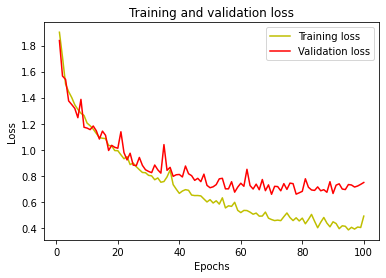

In [23]:
# Plot loss history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

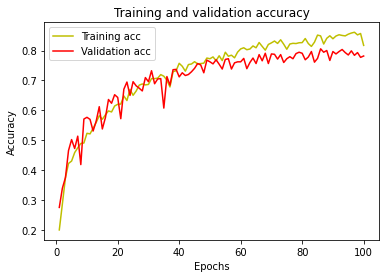

In [24]:
# Plot accuracy history
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

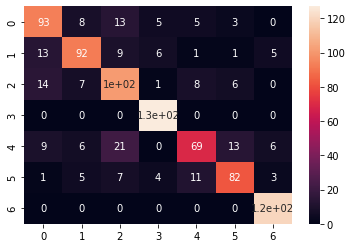

In [25]:
# Predict test
y_pred = model.predict(X_test)

# Convert to one hot 
y_true = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Test confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True)
plt.show()

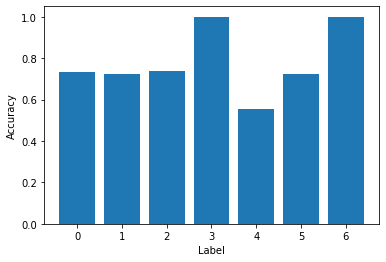

In [26]:
# Percentage correct
correct = np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), correct)
plt.xlabel('Label')
plt.ylabel('Accuracy')
plt.show()

In [27]:
model.save("model.h5")